In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import LSTM,Dense,Dropout
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(r'C:\Users\HAMED\miniconda3\MyCSV-FX\BTC-3years.csv')
df.head()

,Date,Open,High,Low,Close
0,09/10/2021,"46,265","47,041","44,879","45,094"
1,09/09/2021,"46,154","47,384","45,586","46,268"
2,09/08/2021,"46,825","47,357","44,548","46,154"
3,09/07/2021,"51,930","52,918","43,917","46,777"
4,09/06/2021,"51,753","52,142","51,044","51,930"


In [3]:
df['Close'] = df[['Close']].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
df = df.set_index("Date")[['Close']]
df = df.set_index(pd.to_datetime(df.index))
df = df[::-1]
df.head()

,Close
Date,
2020-09-10,10.307
2020-09-11,10.329
2020-09-12,10.447
2020-09-13,10.324
2020-09-14,10.694


In [4]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns , index = df.index)
df.head()

,Close
Date,
2020-09-10,0.001712
2020-09-11,0.002125
2020-09-12,0.004345
2020-09-13,0.002031
2020-09-14,0.008991


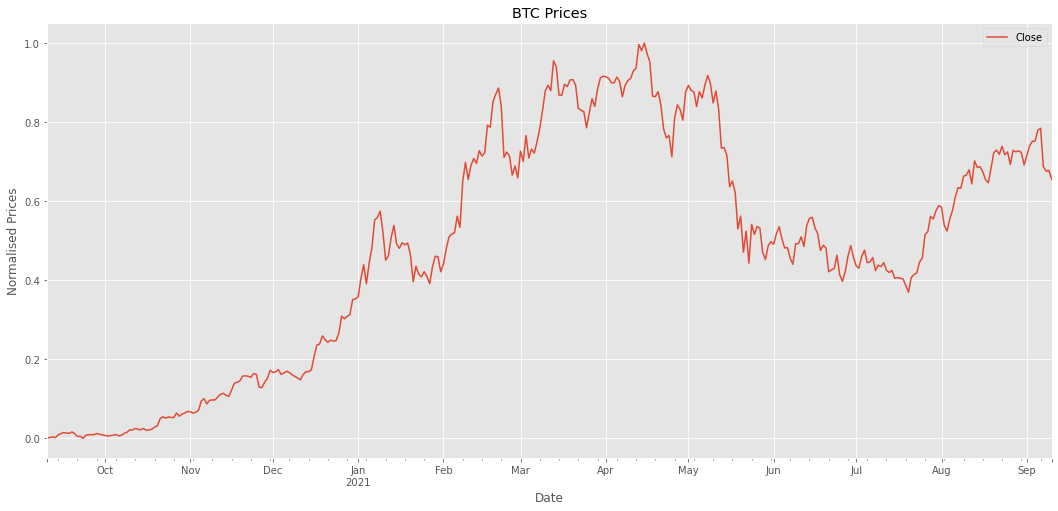

In [5]:
df.plot(figsize=(18,8))
plt.title('BTC Prices')
plt.ylabel('Normalised Prices')
plt.show()

In [6]:
def split_sequences(seq, n_steps_in , n_steps_out):  # X = inputs / Y = results
    X,y = [],[]
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        
        if out_end > len(seq):
            break
            
        seq_x ,seq_y = seq[i:end] , seq[end:out_end]
    
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X) , np.array(y)

In [7]:
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('loss')
    plt.xlabel('Epoches')
    plt.ylabel('loss')
    plt.show()
    
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc','acc'])
    plt.title('accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.show()

In [8]:
n_per_in = 30
n_per_out = 10
n_features = 1

X,y = split_sequences(list(df.Close), n_per_in ,n_per_out )

print(X.shape)

X = X.reshape(X.shape[0],X.shape[1],n_features)

print(X.shape)

(327, 30)
(327, 30, 1)


In [28]:
model = Sequential()
model.add(LSTM(96 , return_sequences=True, input_shape=(n_per_in,n_features)))
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96, return_sequences=True)) #hidden layer
model.add(LSTM(96 ))   #output layer
model.add(Dense(n_per_out, activation ='sigmoid')) #should have the same amount as we want to predict

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 96)            37632     
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 96)            74112     
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 96)            74112     
_________________________________________________________________
lstm_12 (LSTM)               (None, 30, 96)            74112     
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 96)            74112     
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 96)            74112     
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 96)           

In [29]:
model.compile(optimizer='adam', loss='mse', metrics=['acc'])  #MSE is a numerical feature

In [30]:
if (not os.path.exists(r'C:\Users\HAMED\miniconda3\myLSTMNN\prediction_BTC_2h.h5')) :
    res = model.fit(X,y, epochs=2000 ,batch_size=327, validation_split=0.33)
    model.save(r'C:\Users\HAMED\miniconda3\myLSTMNN\prediction_BTC_2h.h5')

Epoch 1/2000
1/1 [==============================] - 34s 34s/step - loss: 0.1007 - acc: 0.0548 - val_loss: 0.0141 - val_acc: 0.0741
Epoch 2/2000
1/1 [==============================] - 1s 1s/step - loss: 0.1006 - acc: 0.0457 - val_loss: 0.0138 - val_acc: 0.0741
Epoch 3/2000
1/1 [==============================] - 1s 1s/step - loss: 0.1005 - acc: 0.0457 - val_loss: 0.0136 - val_acc: 0.0741
Epoch 4/2000
1/1 [==============================] - 1s 1s/step - loss: 0.1004 - acc: 0.0457 - val_loss: 0.0133 - val_acc: 0.0741
Epoch 5/2000
1/1 [==============================] - 1s 1s/step - loss: 0.1002 - acc: 0.0457 - val_loss: 0.0130 - val_acc: 0.0741
Epoch 6/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0998 - acc: 0.0457 - val_loss: 0.0128 - val_acc: 0.0741
Epoch 7/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0987 - acc: 0.1644 - val_loss: 0.0127 - val_acc: 0.1944
Epoch 8/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0959 - acc: 0.2420 - v

1/1 [==============================] - 1s 1s/step - loss: 0.0067 - acc: 0.2831 - val_loss: 0.0773 - val_acc: 0.1204
Epoch 65/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0067 - acc: 0.2603 - val_loss: 0.0705 - val_acc: 0.1111
Epoch 66/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0067 - acc: 0.2466 - val_loss: 0.0834 - val_acc: 0.1111
Epoch 67/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0072 - acc: 0.2603 - val_loss: 0.0639 - val_acc: 0.1111
Epoch 68/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0077 - acc: 0.2283 - val_loss: 0.0906 - val_acc: 0.1481
Epoch 69/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0085 - acc: 0.2831 - val_loss: 0.0787 - val_acc: 0.2315
Epoch 70/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0065 - acc: 0.2785 - val_loss: 0.0602 - val_acc: 0.2315
Epoch 71/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0093 - acc: 0.2466 - val_loss:

Epoch 127/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0052 - acc: 0.2877 - val_loss: 0.0788 - val_acc: 0.1852
Epoch 128/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2877 - val_loss: 0.0827 - val_acc: 0.1481
Epoch 129/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0055 - acc: 0.2968 - val_loss: 0.0778 - val_acc: 0.1667
Epoch 130/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0055 - acc: 0.2877 - val_loss: 0.0832 - val_acc: 0.1389
Epoch 131/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2877 - val_loss: 0.0796 - val_acc: 0.1759
Epoch 132/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.2740 - val_loss: 0.0801 - val_acc: 0.1574
Epoch 133/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0049 - acc: 0.2922 - val_loss: 0.0793 - val_acc: 0.1389
Epoch 134/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0049 - a

1/1 [==============================] - 1s 1s/step - loss: 0.0060 - acc: 0.2968 - val_loss: 0.0729 - val_acc: 0.1667
Epoch 190/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0052 - acc: 0.3151 - val_loss: 0.0789 - val_acc: 0.1574
Epoch 191/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2785 - val_loss: 0.0792 - val_acc: 0.1481
Epoch 192/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.3059 - val_loss: 0.0740 - val_acc: 0.1852
Epoch 193/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0059 - acc: 0.3196 - val_loss: 0.0776 - val_acc: 0.2315
Epoch 194/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0046 - acc: 0.3151 - val_loss: 0.0817 - val_acc: 0.1759
Epoch 195/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0059 - acc: 0.2968 - val_loss: 0.0765 - val_acc: 0.1852
Epoch 196/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0054 - acc: 0.3333 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0072 - acc: 0.1963 - val_loss: 0.0826 - val_acc: 0.1481
Epoch 252/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0065 - acc: 0.2009 - val_loss: 0.0854 - val_acc: 0.1019
Epoch 253/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0083 - acc: 0.1918 - val_loss: 0.0814 - val_acc: 0.1204
Epoch 254/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0077 - acc: 0.1689 - val_loss: 0.0729 - val_acc: 0.1481
Epoch 255/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0060 - acc: 0.1918 - val_loss: 0.0643 - val_acc: 0.1944
Epoch 256/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0063 - acc: 0.1963 - val_loss: 0.0619 - val_acc: 0.1852
Epoch 257/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0072 - acc: 0.1872 - val_loss: 0.0663 - val_acc: 0.1759
Epoch 258/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0056 - acc: 0.2100 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2877 - val_loss: 0.0740 - val_acc: 0.2037
Epoch 314/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0048 - acc: 0.2831 - val_loss: 0.0739 - val_acc: 0.2037
Epoch 315/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0044 - acc: 0.3014 - val_loss: 0.0733 - val_acc: 0.2222
Epoch 316/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0044 - acc: 0.3059 - val_loss: 0.0748 - val_acc: 0.2315
Epoch 317/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0046 - acc: 0.3288 - val_loss: 0.0782 - val_acc: 0.2130
Epoch 318/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0045 - acc: 0.3333 - val_loss: 0.0821 - val_acc: 0.2130
Epoch 319/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0043 - acc: 0.3379 - val_loss: 0.0871 - val_acc: 0.2130
Epoch 320/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0043 - acc: 0.3288 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 0.2877 - val_loss: 0.0790 - val_acc: 0.2130
Epoch 376/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.2557 - val_loss: 0.0803 - val_acc: 0.1852
Epoch 377/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.2785 - val_loss: 0.0786 - val_acc: 0.2130
Epoch 378/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0041 - acc: 0.2603 - val_loss: 0.0805 - val_acc: 0.1852
Epoch 379/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.2877 - val_loss: 0.0798 - val_acc: 0.1852
Epoch 380/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0035 - acc: 0.2785 - val_loss: 0.0787 - val_acc: 0.1944
Epoch 381/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.2648 - val_loss: 0.0796 - val_acc: 0.1389
Epoch 382/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0043 - acc: 0.2785 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 0.2603 - val_loss: 0.0797 - val_acc: 0.1759
Epoch 438/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.2740 - val_loss: 0.0786 - val_acc: 0.1759
Epoch 439/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.2648 - val_loss: 0.0781 - val_acc: 0.1667
Epoch 440/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0039 - acc: 0.2740 - val_loss: 0.0771 - val_acc: 0.1944
Epoch 441/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2694 - val_loss: 0.0812 - val_acc: 0.1759
Epoch 442/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0043 - acc: 0.2922 - val_loss: 0.0786 - val_acc: 0.1574
Epoch 443/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.2648 - val_loss: 0.0728 - val_acc: 0.2130
Epoch 444/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0099 - acc: 0.2146 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.3059 - val_loss: 0.0801 - val_acc: 0.1481
Epoch 500/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0039 - acc: 0.2877 - val_loss: 0.0800 - val_acc: 0.1389
Epoch 501/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.2831 - val_loss: 0.0791 - val_acc: 0.1667
Epoch 502/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 0.2785 - val_loss: 0.0790 - val_acc: 0.1667
Epoch 503/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 0.2785 - val_loss: 0.0790 - val_acc: 0.1481
Epoch 504/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.2831 - val_loss: 0.0792 - val_acc: 0.1667
Epoch 505/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0044 - acc: 0.2511 - val_loss: 0.0808 - val_acc: 0.1667
Epoch 506/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.2740 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3151 - val_loss: 0.0790 - val_acc: 0.1759
Epoch 562/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3196 - val_loss: 0.0794 - val_acc: 0.1759
Epoch 563/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3196 - val_loss: 0.0798 - val_acc: 0.1667
Epoch 564/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.2968 - val_loss: 0.0795 - val_acc: 0.1759
Epoch 565/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.2968 - val_loss: 0.0794 - val_acc: 0.1667
Epoch 566/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.2968 - val_loss: 0.0793 - val_acc: 0.1574
Epoch 567/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0034 - acc: 0.2922 - val_loss: 0.0796 - val_acc: 0.1574
Epoch 568/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0039 - acc: 0.2877 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.2831 - val_loss: 0.0746 - val_acc: 0.1296
Epoch 624/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0060 - acc: 0.2831 - val_loss: 0.0720 - val_acc: 0.1667
Epoch 625/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0050 - acc: 0.2831 - val_loss: 0.0692 - val_acc: 0.1389
Epoch 626/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0056 - acc: 0.2785 - val_loss: 0.0641 - val_acc: 0.1574
Epoch 627/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.3196 - val_loss: 0.0605 - val_acc: 0.1481
Epoch 628/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0054 - acc: 0.3242 - val_loss: 0.0620 - val_acc: 0.1481
Epoch 629/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0050 - acc: 0.3288 - val_loss: 0.0673 - val_acc: 0.1481
Epoch 630/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.3333 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.3105 - val_loss: 0.0805 - val_acc: 0.1944
Epoch 686/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3242 - val_loss: 0.0792 - val_acc: 0.1944
Epoch 687/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.3242 - val_loss: 0.0779 - val_acc: 0.2037
Epoch 688/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0045 - acc: 0.3242 - val_loss: 0.0797 - val_acc: 0.1944
Epoch 689/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.3425 - val_loss: 0.0778 - val_acc: 0.1852
Epoch 690/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0048 - acc: 0.3425 - val_loss: 0.0741 - val_acc: 0.1852
Epoch 691/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0080 - acc: 0.3059 - val_loss: 0.0759 - val_acc: 0.1852
Epoch 692/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0067 - acc: 0.3059 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.3288 - val_loss: 0.0782 - val_acc: 0.1852
Epoch 748/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0041 - acc: 0.2968 - val_loss: 0.0794 - val_acc: 0.1852
Epoch 749/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0035 - acc: 0.3470 - val_loss: 0.0776 - val_acc: 0.1574
Epoch 750/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0040 - acc: 0.3333 - val_loss: 0.0776 - val_acc: 0.1852
Epoch 751/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.3014 - val_loss: 0.0797 - val_acc: 0.1944
Epoch 752/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0046 - acc: 0.3014 - val_loss: 0.0804 - val_acc: 0.1667
Epoch 753/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0048 - acc: 0.3014 - val_loss: 0.0746 - val_acc: 0.1389
Epoch 754/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0041 - acc: 0.3151 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.3105 - val_loss: 0.0807 - val_acc: 0.1481
Epoch 810/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - acc: 0.3196 - val_loss: 0.0808 - val_acc: 0.1481
Epoch 811/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3059 - val_loss: 0.0808 - val_acc: 0.1574
Epoch 812/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0033 - acc: 0.3105 - val_loss: 0.0802 - val_acc: 0.1667
Epoch 813/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - acc: 0.3196 - val_loss: 0.0792 - val_acc: 0.1667
Epoch 814/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - acc: 0.3242 - val_loss: 0.0782 - val_acc: 0.1667
Epoch 815/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0032 - acc: 0.3105 - val_loss: 0.0778 - val_acc: 0.1852
Epoch 816/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - acc: 0.3379 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0030 - acc: 0.3425 - val_loss: 0.0795 - val_acc: 0.1667
Epoch 872/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3288 - val_loss: 0.0793 - val_acc: 0.1667
Epoch 873/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3288 - val_loss: 0.0790 - val_acc: 0.1759
Epoch 874/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3288 - val_loss: 0.0789 - val_acc: 0.1667
Epoch 875/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3333 - val_loss: 0.0790 - val_acc: 0.1574
Epoch 876/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3379 - val_loss: 0.0791 - val_acc: 0.1667
Epoch 877/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - acc: 0.3242 - val_loss: 0.0793 - val_acc: 0.1574
Epoch 878/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - acc: 0.3425 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - val_loss: 0.0786 - val_acc: 0.1574
Epoch 934/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3607 - val_loss: 0.0787 - val_acc: 0.1574
Epoch 935/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - val_loss: 0.0784 - val_acc: 0.1667
Epoch 936/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - acc: 0.3562 - val_loss: 0.0789 - val_acc: 0.1667
Epoch 937/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0030 - acc: 0.3425 - val_loss: 0.0787 - val_acc: 0.1481
Epoch 938/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - val_loss: 0.0791 - val_acc: 0.1667
Epoch 939/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3516 - val_loss: 0.0787 - val_acc: 0.1574
Epoch 940/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - va

1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - val_loss: 0.0781 - val_acc: 0.1574
Epoch 996/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3699 - val_loss: 0.0785 - val_acc: 0.1574
Epoch 997/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0782 - val_acc: 0.1574
Epoch 998/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3699 - val_loss: 0.0785 - val_acc: 0.1667
Epoch 999/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0781 - val_acc: 0.1667
Epoch 1000/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3653 - val_loss: 0.0784 - val_acc: 0.1667
Epoch 1001/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0779 - val_acc: 0.1574
Epoch 1002/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3607 -

1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0781 - val_acc: 0.1667
Epoch 1058/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3653 - val_loss: 0.0776 - val_acc: 0.1667
Epoch 1059/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0783 - val_acc: 0.1667
Epoch 1060/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3699 - val_loss: 0.0778 - val_acc: 0.1574
Epoch 1061/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0781 - val_acc: 0.1574
Epoch 1062/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - acc: 0.3562 - val_loss: 0.0771 - val_acc: 0.1667
Epoch 1063/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0772 - val_acc: 0.1759
Epoch 1064/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0027 - acc: 0.36

1/1 [==============================] - 1s 1s/step - loss: 0.0063 - acc: 0.3379 - val_loss: 0.0663 - val_acc: 0.1944
Epoch 1120/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0063 - acc: 0.3516 - val_loss: 0.0576 - val_acc: 0.1944
Epoch 1121/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0058 - acc: 0.3333 - val_loss: 0.0557 - val_acc: 0.1852
Epoch 1122/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0060 - acc: 0.3151 - val_loss: 0.0588 - val_acc: 0.1389
Epoch 1123/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0056 - acc: 0.2785 - val_loss: 0.0642 - val_acc: 0.1296
Epoch 1124/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0051 - acc: 0.2968 - val_loss: 0.0712 - val_acc: 0.1111
Epoch 1125/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0054 - acc: 0.2785 - val_loss: 0.0793 - val_acc: 0.1111
Epoch 1126/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0052 - acc: 0.27

1/1 [==============================] - 1s 1s/step - loss: 0.0035 - acc: 0.3562 - val_loss: 0.0779 - val_acc: 0.1759
Epoch 1182/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.3607 - val_loss: 0.0760 - val_acc: 0.2037
Epoch 1183/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0038 - acc: 0.3425 - val_loss: 0.0793 - val_acc: 0.1852
Epoch 1184/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0044 - acc: 0.3196 - val_loss: 0.0801 - val_acc: 0.1667
Epoch 1185/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.3196 - val_loss: 0.0737 - val_acc: 0.1296
Epoch 1186/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0056 - acc: 0.3242 - val_loss: 0.0762 - val_acc: 0.2037
Epoch 1187/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0062 - acc: 0.2740 - val_loss: 0.0780 - val_acc: 0.1852
Epoch 1188/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0055 - acc: 0.29

1/1 [==============================] - 2s 2s/step - loss: 0.0031 - acc: 0.3242 - val_loss: 0.0789 - val_acc: 0.1852
Epoch 1244/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - acc: 0.3059 - val_loss: 0.0781 - val_acc: 0.1852
Epoch 1245/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - acc: 0.3242 - val_loss: 0.0793 - val_acc: 0.1852
Epoch 1246/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - acc: 0.3151 - val_loss: 0.0783 - val_acc: 0.1944
Epoch 1247/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - acc: 0.3242 - val_loss: 0.0795 - val_acc: 0.1759
Epoch 1248/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - acc: 0.3242 - val_loss: 0.0783 - val_acc: 0.1852
Epoch 1249/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0031 - acc: 0.3288 - val_loss: 0.0785 - val_acc: 0.1667
Epoch 1250/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0030 - acc: 0.33

1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3333 - val_loss: 0.0790 - val_acc: 0.1759
Epoch 1306/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3333 - val_loss: 0.0791 - val_acc: 0.1759
Epoch 1307/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3379 - val_loss: 0.0789 - val_acc: 0.1759
Epoch 1308/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3333 - val_loss: 0.0788 - val_acc: 0.1759
Epoch 1309/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3425 - val_loss: 0.0788 - val_acc: 0.1759
Epoch 1310/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3425 - val_loss: 0.0788 - val_acc: 0.1759
Epoch 1311/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3379 - val_loss: 0.0789 - val_acc: 0.1667
Epoch 1312/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.34

1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0787 - val_acc: 0.1759
Epoch 1368/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3425 - val_loss: 0.0787 - val_acc: 0.1481
Epoch 1369/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0786 - val_acc: 0.1759
Epoch 1370/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3470 - val_loss: 0.0787 - val_acc: 0.1481
Epoch 1371/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0786 - val_acc: 0.1759
Epoch 1372/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3470 - val_loss: 0.0787 - val_acc: 0.1574
Epoch 1373/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0787 - val_acc: 0.1667
Epoch 1374/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.34

1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0783 - val_acc: 0.1852
Epoch 1430/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0784 - val_acc: 0.1667
Epoch 1431/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0785 - val_acc: 0.1944
Epoch 1432/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0787 - val_acc: 0.1759
Epoch 1433/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0787 - val_acc: 0.1944
Epoch 1434/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3699 - val_loss: 0.0787 - val_acc: 0.1574
Epoch 1435/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0787 - val_acc: 0.1852
Epoch 1436/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0783 - val_acc: 0.1852
Epoch 1492/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3653 - val_loss: 0.0782 - val_acc: 0.1667
Epoch 1493/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0784 - val_acc: 0.1852
Epoch 1494/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3653 - val_loss: 0.0782 - val_acc: 0.1667
Epoch 1495/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0784 - val_acc: 0.1852
Epoch 1496/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3653 - val_loss: 0.0782 - val_acc: 0.1667
Epoch 1497/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3562 - val_loss: 0.0784 - val_acc: 0.1852
Epoch 1498/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0782 - val_acc: 0.1944
Epoch 1554/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0779 - val_acc: 0.1759
Epoch 1555/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0782 - val_acc: 0.1944
Epoch 1556/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0779 - val_acc: 0.1759
Epoch 1557/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0782 - val_acc: 0.1944
Epoch 1558/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0779 - val_acc: 0.1759
Epoch 1559/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0781 - val_acc: 0.1944
Epoch 1560/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3699 - val_loss: 0.0776 - val_acc: 0.1852
Epoch 1616/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0777 - val_acc: 0.1852
Epoch 1617/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0775 - val_acc: 0.1759
Epoch 1618/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3516 - val_loss: 0.0781 - val_acc: 0.1852
Epoch 1619/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0777 - val_acc: 0.1759
Epoch 1620/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3607 - val_loss: 0.0783 - val_acc: 0.1944
Epoch 1621/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0780 - val_acc: 0.1852
Epoch 1622/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.35

1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.3653 - val_loss: 0.0776 - val_acc: 0.1852
Epoch 1678/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0773 - val_acc: 0.1759
Epoch 1679/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3470 - val_loss: 0.0781 - val_acc: 0.1852
Epoch 1680/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0029 - acc: 0.3516 - val_loss: 0.0774 - val_acc: 0.1759
Epoch 1681/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.3516 - val_loss: 0.0778 - val_acc: 0.1852
Epoch 1682/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0773 - val_acc: 0.1759
Epoch 1683/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3470 - val_loss: 0.0776 - val_acc: 0.1852
Epoch 1684/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3699 - val_loss: 0.0775 - val_acc: 0.1852
Epoch 1740/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0770 - val_acc: 0.1759
Epoch 1741/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3562 - val_loss: 0.0779 - val_acc: 0.1852
Epoch 1742/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0774 - val_acc: 0.1759
Epoch 1743/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3607 - val_loss: 0.0778 - val_acc: 0.1667
Epoch 1744/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.3607 - val_loss: 0.0774 - val_acc: 0.1667
Epoch 1745/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.3699 - val_loss: 0.0769 - val_acc: 0.1852
Epoch 1746/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.36

1/1 [==============================] - 1s 1s/step - loss: 0.0028 - acc: 0.3470 - val_loss: 0.0767 - val_acc: 0.1759
Epoch 1802/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0027 - acc: 0.3790 - val_loss: 0.0778 - val_acc: 0.1759
Epoch 1803/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0027 - acc: 0.3516 - val_loss: 0.0774 - val_acc: 0.1759
Epoch 1804/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0026 - acc: 0.3744 - val_loss: 0.0778 - val_acc: 0.1759
Epoch 1805/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.3562 - val_loss: 0.0772 - val_acc: 0.1852
Epoch 1806/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0026 - acc: 0.3836 - val_loss: 0.0772 - val_acc: 0.1667
Epoch 1807/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0026 - acc: 0.3562 - val_loss: 0.0765 - val_acc: 0.1759
Epoch 1808/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0025 - acc: 0.3699 - val_loss: 0.0767 - val_acc: 0.1852
Epoch 1864/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - acc: 0.3699 - val_loss: 0.0765 - val_acc: 0.1574
Epoch 1865/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - acc: 0.3699 - val_loss: 0.0764 - val_acc: 0.1667
Epoch 1866/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0025 - acc: 0.3790 - val_loss: 0.0770 - val_acc: 0.1667
Epoch 1867/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - acc: 0.3562 - val_loss: 0.0764 - val_acc: 0.1759
Epoch 1868/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0029 - acc: 0.3516 - val_loss: 0.0781 - val_acc: 0.1759
Epoch 1869/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0029 - acc: 0.3516 - val_loss: 0.0771 - val_acc: 0.1759
Epoch 1870/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0028 - acc: 0.36

1/1 [==============================] - 2s 2s/step - loss: 0.0059 - acc: 0.2648 - val_loss: 0.0636 - val_acc: 0.0648
Epoch 1926/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0064 - acc: 0.2740 - val_loss: 0.0603 - val_acc: 0.0648
Epoch 1927/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0060 - acc: 0.2648 - val_loss: 0.0606 - val_acc: 0.0741
Epoch 1928/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0060 - acc: 0.2694 - val_loss: 0.0621 - val_acc: 0.1204
Epoch 1929/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0057 - acc: 0.2785 - val_loss: 0.0645 - val_acc: 0.1759
Epoch 1930/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0052 - acc: 0.3105 - val_loss: 0.0681 - val_acc: 0.2037
Epoch 1931/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0054 - acc: 0.3196 - val_loss: 0.0727 - val_acc: 0.1759
Epoch 1932/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0053 - acc: 0.30

1/1 [==============================] - 1s 1s/step - loss: 0.0036 - acc: 0.3425 - val_loss: 0.0738 - val_acc: 0.1389
Epoch 1988/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0040 - acc: 0.3151 - val_loss: 0.0748 - val_acc: 0.1759
Epoch 1989/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0037 - acc: 0.3516 - val_loss: 0.0746 - val_acc: 0.2315
Epoch 1990/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0036 - acc: 0.3607 - val_loss: 0.0741 - val_acc: 0.2407
Epoch 1991/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0039 - acc: 0.3744 - val_loss: 0.0788 - val_acc: 0.2315
Epoch 1992/2000
1/1 [==============================] - 2s 2s/step - loss: 0.0034 - acc: 0.3562 - val_loss: 0.0799 - val_acc: 0.2037
Epoch 1993/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0037 - acc: 0.3653 - val_loss: 0.0781 - val_acc: 0.1944
Epoch 1994/2000
1/1 [==============================] - 1s 1s/step - loss: 0.0034 - acc: 0.33

In [31]:
model_res = load_model(r'C:\Users\HAMED\miniconda3\myLSTMNN\prediction_BTC_2h.h5')

In [32]:
loss, acc = model_res.evaluate(X, y, verbose=0)
print( 'loss: %f, acc: %f' % (loss, acc*100))

loss: 0.027037, acc: 25.993884


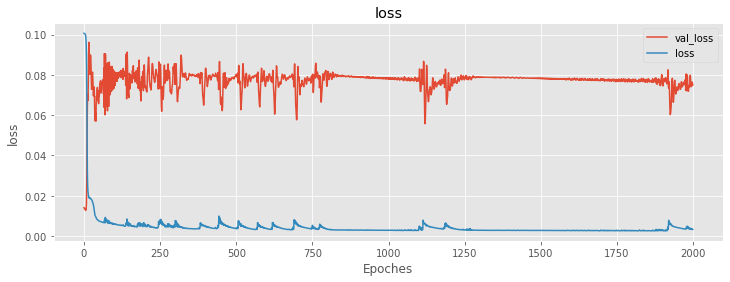

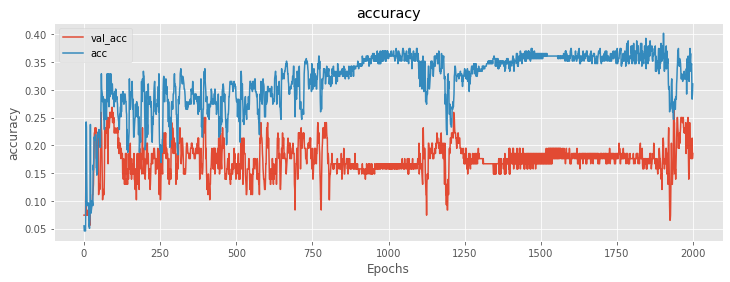

In [33]:
visualize_results(res)

predicted [[48.23769753491878], [48.863469129562375], [50.54308376944065], [52.17458529001474], [52.79989422804117], [54.190960076212875], [54.969170688450326], [54.53844054675101], [55.39647526985406], [55.69703412032126]]
actual [[48.279], [49.556], [50.184], [50.195], [51.652], [51.93], [46.777], [46.154], [46.268], [45.094]]


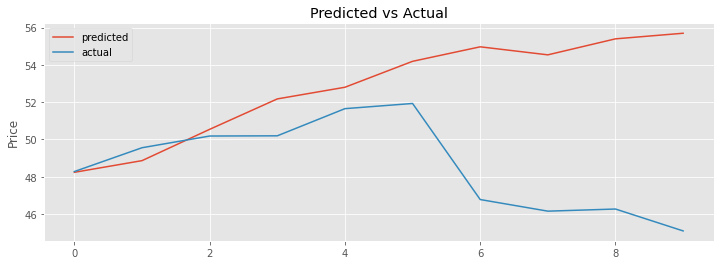

In [34]:
plt.figure(figsize=(12,4))

yhat = model.predict(X[-1].reshape(1,n_per_in,n_features)).tolist()[0]

yhat =scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

actual =scaler.inverse_transform(y[-1].reshape(-1,1))

print('predicted' , yhat)
plt.plot(yhat , label='predicted')

print('actual', actual.tolist())

plt.plot(actual.tolist(), label='actual')

plt.title('Predicted vs Actual')
plt.ylabel('Price')
plt.legend()
plt.show()

                Close
2021-09-10  55.834228
2021-09-11  56.175728
2021-09-12  58.509435
2021-09-13  56.851521
2021-09-14  58.218899
2021-09-15  58.291834
2021-09-16  57.445417
2021-09-17  56.410039
2021-09-18  57.580376
2021-09-19  57.667558


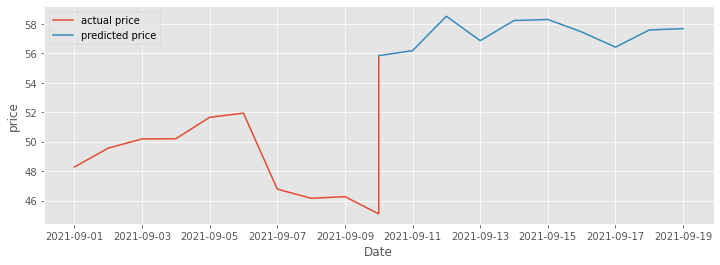

In [35]:
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1,n_per_in,n_features)).tolist()
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

preds = pd.DataFrame(yhat , index= pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

print(preds)

periods = 10

actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)) , index = df.Close.tail(periods).index, columns=df.columns).append(preds.head(1))

plt.figure(figsize=(12,4))
plt.plot(actual , label = "actual price")
plt.plot(preds , label="predicted price")


plt.ylabel('price')
plt.xlabel('Date')

plt.legend()
plt.show()